# Análisis discriminante: ajuste del modelo

## Análisis discriminante cuadrático

Al igual que naive Bayes, QDA se ajusta mediante maximización de la log-verosimilitud conjunta:
$$\begin{align*}
\log p(\mathcal{D}\mid\boldsymbol{\theta})%
&=\sum_c N_c\log\pi_c + \sum_c\sum_{n:y_n=c}\log \mathcal{N}(\boldsymbol{x}_n\mid \boldsymbol{\mu}_c,\mathbf{\Sigma}_c)\\%
\end{align*}$$
De nuevo tenemos que la maximización puede hacerse separadamente. Por un lado, la maximización en $\boldsymbol{\pi}$ da lugar a las bien conocidas proporciones de datos de entrenamiento por clase. Por otro lado, la maximización del resto de parámetros puede hacerse separadamente, clase a clase, ya que $\boldsymbol{\mu}_c$ y $\mathbf{\Sigma}_c$ solo dependen de los datos de entrenamiento de clase $c$. De hecho, el MLE de $\boldsymbol{\mu}_c$ y $\mathbf{\Sigma}_c$ es el mismo que obtendríamos considerando la Gaussiana $c$-ésima y los datos de la clase $c$ aisladamente:
$$\begin{align*}
\hat{\boldsymbol{\mu}}_c&=\frac{1}{N_c}\sum_{n:y_n=c}\boldsymbol{x}_n\\%
\hat{\mathbf{\Sigma}}_c&=\frac{1}{N_c}\sum_{n:y_n=c}(\boldsymbol{x}_n-\hat{\boldsymbol{\mu}}_c)(\boldsymbol{x}_n-\hat{\boldsymbol{\mu}}_c)^t%
\end{align*}$$
En general, $\hat{\mathbf{\Sigma}}_c$ se sobreajusta a menos que $N_c$ sea mucho mayor que $D$.

**Ejemplo:** $\;C=3$, $\;D=2$, $\;\pi_1=\pi_2=\pi_3=1/3$
$$\begin{align*}
\boldsymbol{\mu}_1&=(0, 0)^t & \boldsymbol{\mu}_2&=(0, 4)^t & \boldsymbol{\mu}_3&=(4, 4)^t\\%
\mathbf{\Sigma}_1&=\begin{pmatrix}4&1\\1&2\end{pmatrix}%
&\mathbf{\Sigma}_2&=\begin{pmatrix}2&0\\0&1\end{pmatrix}%
&\mathbf{\Sigma}_3&=\begin{pmatrix}1&0\\0&1\end{pmatrix}%
\end{align*}$$

In [1]:
import numpy as np
from scipy.stats import multinomial, multivariate_normal
import matplotlib.pyplot as plt

N = 50 # >=3 para tener al menos un dato por clase; en la práctica mucho mayor para evitar matrices singulares
pi1 = pi2 = pi3 = 1/3
yy = multinomial(1, [pi1, pi2, pi3]).rvs(N - 3)
N1 = yy[yy[:, 0] == 1].shape[0] + 1
N2 = yy[yy[:, 1] == 1].shape[0] + 1
N3 = N - N1 - N2
xxy1 = multivariate_normal([0, 0], [[4, 1], [1, 2]]).rvs(N1)
m1 = xxy1.mean(axis=0); S1 = np.cov(xxy1, rowvar=False, bias=True); iS1 = np.linalg.inv(S1)
xxy2 = multivariate_normal([0, 4], [[2, 0], [0, 1]]).rvs(N2)
m2 = xxy2.mean(axis=0); S2 = np.cov(xxy2, rowvar=False, bias=True); iS2 = np.linalg.inv(S2)
xxy3 = multivariate_normal([4, 4], np.eye(2)).rvs(N3)
m3 = xxy3.mean(axis=0); S3 = np.cov(xxy3, rowvar=False, bias=True); iS3 = np.linalg.inv(S3)
print("Medias: ", m1, m2, m3, "\nSigmas:\n", S1, "\n", S2, "\n", S3)

Medias:  [-0.32877558  0.03070221] [0.00733561 3.88443305] [4.18948111 3.72701557] 
Sigmas:
 [[5.17743321 1.1211109 ]
 [1.1211109  1.48395906]] 
 [[1.89233027 0.0149858 ]
 [0.0149858  0.93155948]] 
 [[1.13987187 0.29466172]
 [0.29466172 0.74612851]]


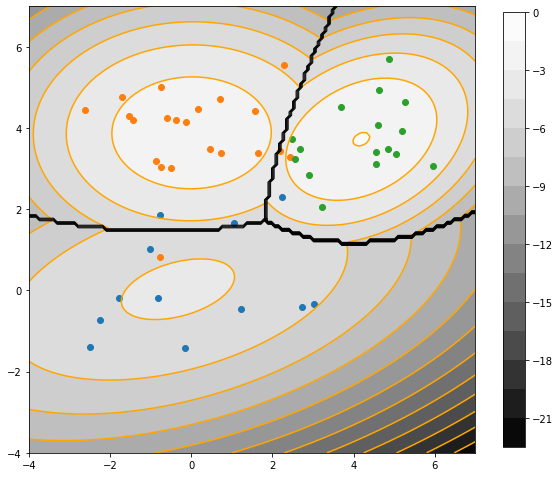

In [2]:
A1, b1, c1 = -0.5 * iS1, iS1 @ m1, np.log(pi1) - 0.5 * np.linalg.det(S1) - 0.5 * m1.T @ iS1 @ m1
A2, b2, c2 = -0.5 * iS2, iS2 @ m2, np.log(pi2) - 0.5 * np.linalg.det(S2) - 0.5 * m2.T @ iS2 @ m2
A3, b3, c3 = -0.5 * iS3, iS3 @ m3, np.log(pi3) - 0.5 * np.linalg.det(S3) - 0.5 * m3.T @ iS3 @ m3
x1, x2 = np.meshgrid(np.linspace(-4, 7, num=128), np.linspace(-4, 7, num=128))
x = np.c_[np.ravel(x1), np.ravel(x2)]
p1 =  lambda x: x.T @ A1 @ x + b1 @ x + c1
p2 =  lambda x: x.T @ A2 @ x + b2 @ x + c2
p3 =  lambda x: x.T @ A3 @ x + b3 @ x + c3
maxp = lambda x: max(p1(x), p2(x), p3(x))
maxpx = np.apply_along_axis(maxp, 1, x)
amaxp = lambda x: np.argmax([p1(x), p2(x), p3(x)])
amaxpx = np.apply_along_axis(amaxp, 1, x)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set(aspect='equal')
ax.contour(x1, x2, maxpx.reshape(x1.shape), 16, colors='orange', linestyles='solid')
cp = ax.contourf(x1, x2, maxpx.reshape(x1.shape), 16, cmap='Greys_r')
ax.contour(x1, x2, amaxpx.reshape(x1.shape), colors='black', linestyles='solid', linewidths=1)
plt.colorbar(cp, ax=ax, shrink=0.8)
ax.set_xlim(-4, 7); ax.set_ylim(-4, 7)
plt.scatter(xxy1[:, 0], xxy1[:, 1])
plt.scatter(xxy2[:, 0], xxy2[:, 1])
plt.scatter(xxy3[:, 0], xxy3[:, 1]);